# APRENDIZAJE AUTOMÁTICO I - PEC 1

El conjunto de datos consiste en un listado de ofertas de alojamientos en la plataforma AirBnB durante 2017.

El objetivo es clasificar los datos según el tipo de alojamiento, a partir del resto de características. Se usan tres tipos de clasificadores: _Naive Bayes_, _KNN_, y _árboles de decisión_.

## 1.Introducción

Primero, se importan las librerias utilizadas

In [2]:
import pandas as pd
import numpy as np

# ML
import sklearn
sklearn.set_config(display="diagram")

# Visualización
import seaborn as sns
sns.set_theme(style="ticks")
import matplotlib.pyplot as plt

# Semilla Aleatoria
semilla_aleatoria = 96

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🛑 MODIFICAR EN FUNCION DE LA CARPETA DE ORIGEN DE LOS DATOS

In [4]:
datos = pd.read_csv('./drive/MyDrive/airbnb.csv')

## 2.Creación del conjunto de evaluación



Lo primero de todo es dividir los datos en los conjuntos de entrenamiento y de evaluación. Para ello se analizan las posibles clases de la variable a clasificar.

In [5]:
datos['room_type'].value_counts()

Entire home/apt    7926
Private room       5203
Shared room         192
Name: room_type, dtype: int64

Esta variable categórica se corresponde con el tipo de habitación. La opción más popular es la vivienda completa, seguido de habitaciones privadas, y por último, espacios compartidos. Las clases de esta variable no están balanceadas, por lo que se usa un muestreo estratificado. Se guardan/separan un 20% de los datos para la evaluación del modelo.

In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(datos, test_size=0.2, stratify=datos["room_type"], random_state=semilla_aleatoria)

El siguiente código muestra que la separación del conjunto de datos en los dos grupos (entrenamiento y evaluación) tienen la misma proporción de cada clase de la variable de interés en el conjunto original.

In [7]:
def room_type_proportions(data):
    return data["room_type"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall %": room_type_proportions(datos),
    "Stratified Train %": room_type_proportions(train_set),
    "Stratified Test %": room_type_proportions(test_set),
}).sort_index()

compare_props.index.name = "Room Type"

(compare_props * 100).round(2)

Overall %  Stratified Train %  Stratified Test %
Room Type                                                        
Entire home/apt      59.50               59.50              59.51
Private room         39.06               39.06              39.06
Shared room           1.44                1.45               1.43

## 3.Exploración de los datos
Se inspeccionan los datos numéricos y las otras dos variables categóricas:

In [8]:
datos.head()

neighbourhood_group  neighbourhood   latitude  longitude        room_type  \
0              Centro       Justicia  40.424715  -3.698638  Entire home/apt   
1              Centro    Embajadores  40.413418  -3.706838  Entire home/apt   
2   Moncloa - Aravaca      Argüelles  40.424920  -3.713446  Entire home/apt   
3   Moncloa - Aravaca  Casa de Campo  40.431027  -3.724586  Entire home/apt   
4              Latina       Cármenes  40.403410  -3.740842     Private room   

   price  minimum_nights  number_of_reviews  reviews_per_month  \
0     49              28                 35               0.42   
1     80               5                 18               0.30   
2     40               2                 21               0.25   
3     55               2                  3               0.13   
4     16               2                 23               0.76   

   calculated_host_listings_count  availability_365  
0                               1                99  
1                               1               188  
2                               9               195  
3                               9               334  
4                               2               250

Como se ve, no faltan datos de ninguna de las variables:

In [9]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             13321 non-null  object 
 1   neighbourhood                   13321 non-null  object 
 2   latitude                        13321 non-null  float64
 3   longitude                       13321 non-null  float64
 4   room_type                       13321 non-null  object 
 5   price                           13321 non-null  int64  
 6   minimum_nights                  13321 non-null  int64  
 7   number_of_reviews               13321 non-null  int64  
 8   reviews_per_month               13321 non-null  float64
 9   calculated_host_listings_count  13321 non-null  int64  
 10  availability_365                13321 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


_neighbourhood_group_ se corresponde con los 21 distritos de Madrid

In [10]:
datos['neighbourhood_group'].value_counts()

Centro                   6773
Chamberí                  960
Salamanca                 883
Arganzuela                790
Tetuán                    463
Moncloa - Aravaca         450
Retiro                    439
Latina                    379
Chamartín                 361
Carabanchel               358
Ciudad Lineal             308
Puente de Vallecas        222
Hortaleza                 185
Fuencarral - El Pardo     170
Usera                     145
San Blas - Canillejas     117
Villaverde                 83
Barajas                    81
Moratalaz                  74
Villa de Vallecas          46
Vicálvaro                  34
Name: neighbourhood_group, dtype: int64

_neighbourhood_ se corresponde con los barrios de Madrid

In [11]:
datos['neighbourhood'].value_counts()

Embajadores       1848
Universidad       1363
Palacio           1084
Sol                942
Justicia           788
                  ... 
Santa Eugenia        4
Hellín               4
Cuatro Vientos       3
Orcasitas            2
El Pardo             1
Name: neighbourhood, Length: 126, dtype: int64

A continuación se presentan estadísticos descriptivos de todas las variables numéricas. Las medias nos dan una idea de los valores esperados para cada variable.

In [12]:
datos.describe()

latitude     longitude         price  minimum_nights  \
count  13321.000000  13321.000000  13321.000000    13321.000000   
mean      40.420730     -3.697268     69.171834        3.010885   
std        0.020344      0.023832    103.721126       12.835619   
min       40.331888     -3.863907      9.000000        1.000000   
25%       40.410090     -3.707856     31.000000        1.000000   
50%       40.418731     -3.701602     53.000000        2.000000   
75%       40.427997     -3.693818     80.000000        3.000000   
max       40.562736     -3.526821   7700.000000     1125.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       13321.000000       13321.000000                    13321.000000   
mean           22.986037           1.520329                        7.605885   
std            38.406006           1.852367                       19.619972   
min             0.000000           0.000000                        1.000000   
25%             1.000000           0.110000                        1.000000   
50%             7.000000           0.780000                        2.000000   
75%            28.000000           2.320000                        4.000000   
max           446.000000          17.210000                      145.000000   

       availability_365  
count      13321.000000  
mean         205.867202  
std          126.968961  
min            0.000000  
25%           84.000000  
50%          247.000000  
75%          321.000000  
max          365.000000

### 3.1.Exploración detallada (datos de entrenamiento)
A continuación se estudian correlaciones, se visualizan los datos de entrenamiento, etc. Es decir, se realiza una exploración más detallada.

A priori, no se observa ningúna correlación a destacar entre variables numéricas. Esto lleva a pensar que en un clasificador (probabilístico) bayesiano ingenuo, la condición de independencia entre las variables predictoras no es una suposición muy descabellada.

In [13]:
train_set.corr()

<ipython-input-13-97f1dac84804>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_set.corr()


latitude  longitude     price  minimum_nights  \
latitude                        1.000000   0.232388  0.062765       -0.006186   
longitude                       0.232388   1.000000 -0.026272       -0.003279   
price                           0.062765  -0.026272  1.000000        0.012398   
minimum_nights                 -0.006186  -0.003279  0.012398        1.000000   
number_of_reviews              -0.065139  -0.035632 -0.034560       -0.034728   
reviews_per_month              -0.066431   0.004083 -0.057427       -0.054721   
calculated_host_listings_count  0.012912  -0.036922  0.077243        0.026183   
availability_365                0.037792  -0.002241  0.057002        0.003817   

                                number_of_reviews  reviews_per_month  \
latitude                                -0.065139          -0.066431   
longitude                               -0.035632           0.004083   
price                                   -0.034560          -0.057427   
minimum_nights                          -0.034728          -0.054721   
number_of_reviews                        1.000000           0.645705   
reviews_per_month                        0.645705           1.000000   
calculated_host_listings_count          -0.085564          -0.131425   
availability_365                         0.078219          -0.002946   

                                calculated_host_listings_count  \
latitude                                              0.012912   
longitude                                            -0.036922   
price                                                 0.077243   
minimum_nights                                        0.026183   
number_of_reviews                                    -0.085564   
reviews_per_month                                    -0.131425   
calculated_host_listings_count                        1.000000   
availability_365                                      0.090805   

                                availability_365  
latitude                                0.037792  
longitude                              -0.002241  
price                                   0.057002  
minimum_nights                          0.003817  
number_of_reviews                       0.078219  
reviews_per_month                      -0.002946  
calculated_host_listings_count          0.090805  
availability_365                        1.000000

La mayoría de las variables presentan distribuciones más discretizadas, ya que los posibles valores son números enteros. Esto no implica que sean datos truncados, simplemente indica la naturaleza de los atributos del conjunto de datos. Solo 3 de las variables puede ser números racionales: reseñas mensuales (_reviews_per_month_), latitud y longitud.

Algunas variables presentan distribuciones más asimétricas con colas bastante pronunciadas, ya que tienen valores atípicos. Por ejemplo, el precio o el número mínimo de noches.

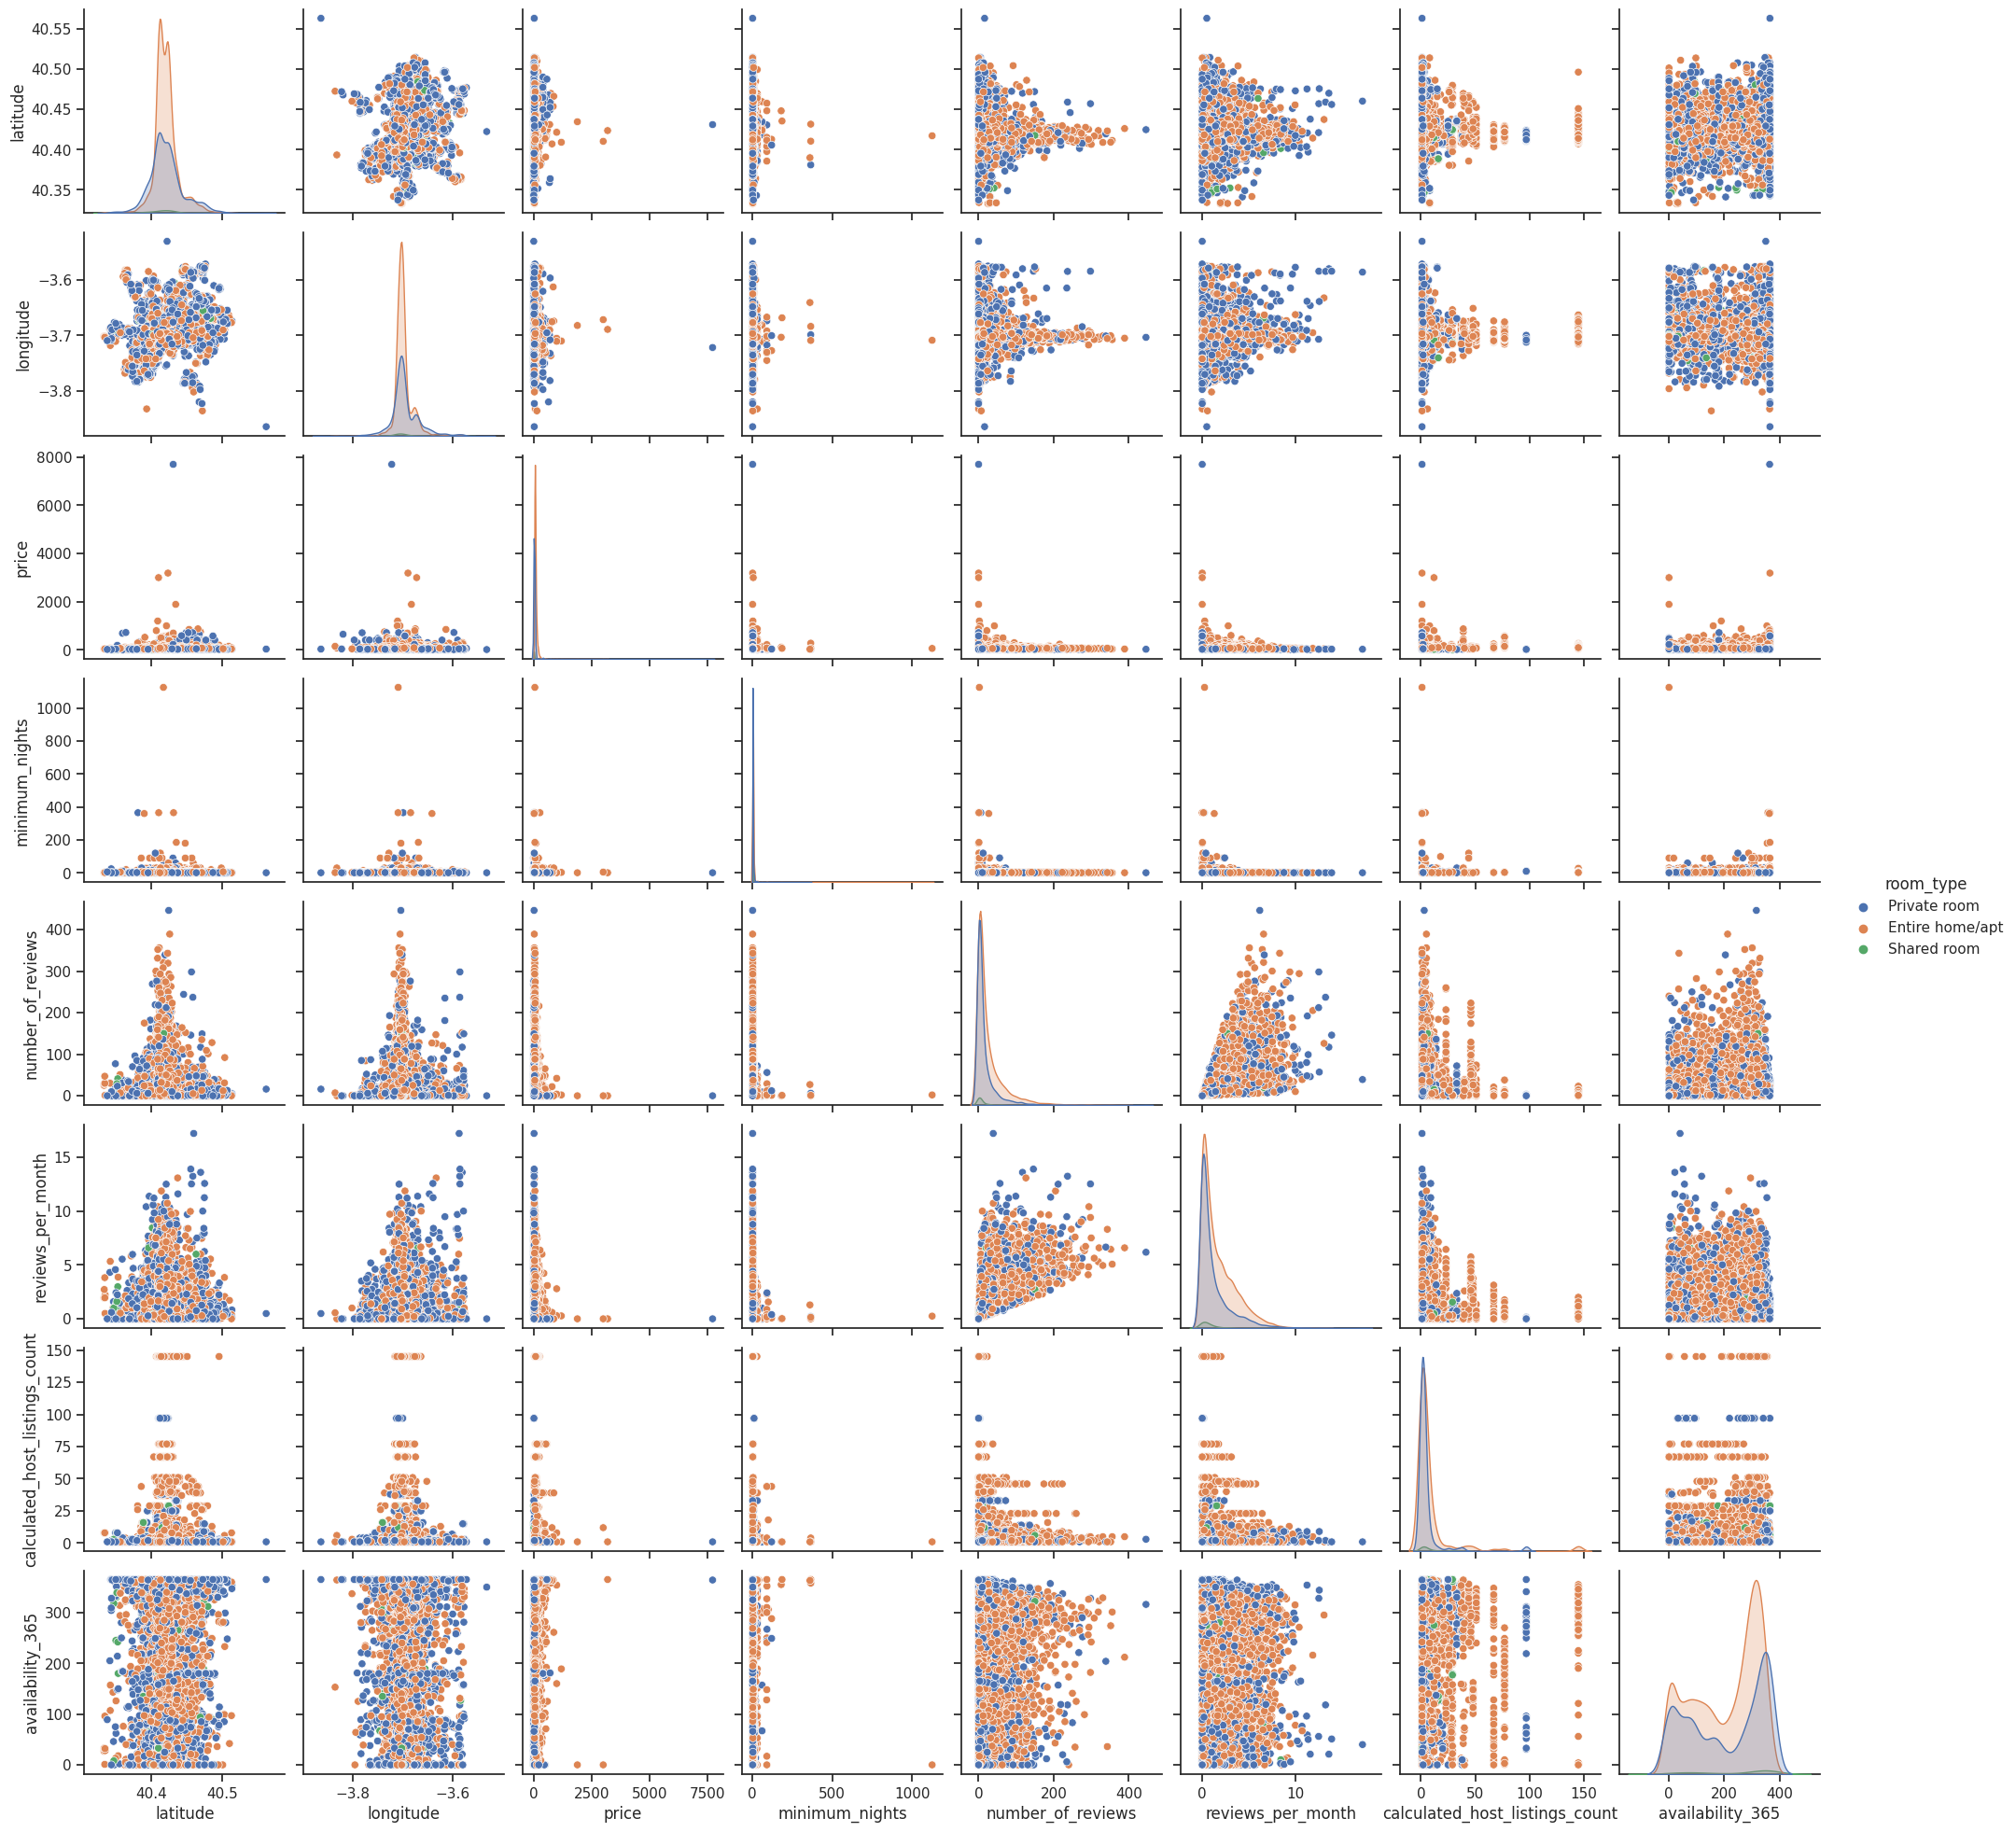

In [14]:
sns.pairplot(train_set, hue="room_type")

## 4.Preparación de los datos


Lo primero de todo es generar copias de los datos de entrenamiento sobre los que se trabajará:

In [15]:
# Estos son Pandas DF
X_train = train_set.drop("room_type", axis=1)
y_train = train_set["room_type"].copy()

Se separan los datos categóricos de los numéricos:

In [16]:
# Estos son Pandas DF
X_train_cat = X_train[["neighbourhood_group", "neighbourhood"]]
X_train_num = X_train.select_dtypes(include=[np.number])

### 4.1.Limpieza de datos

Histogramas de todas las variables numéricas con los datos de entrenamiento:

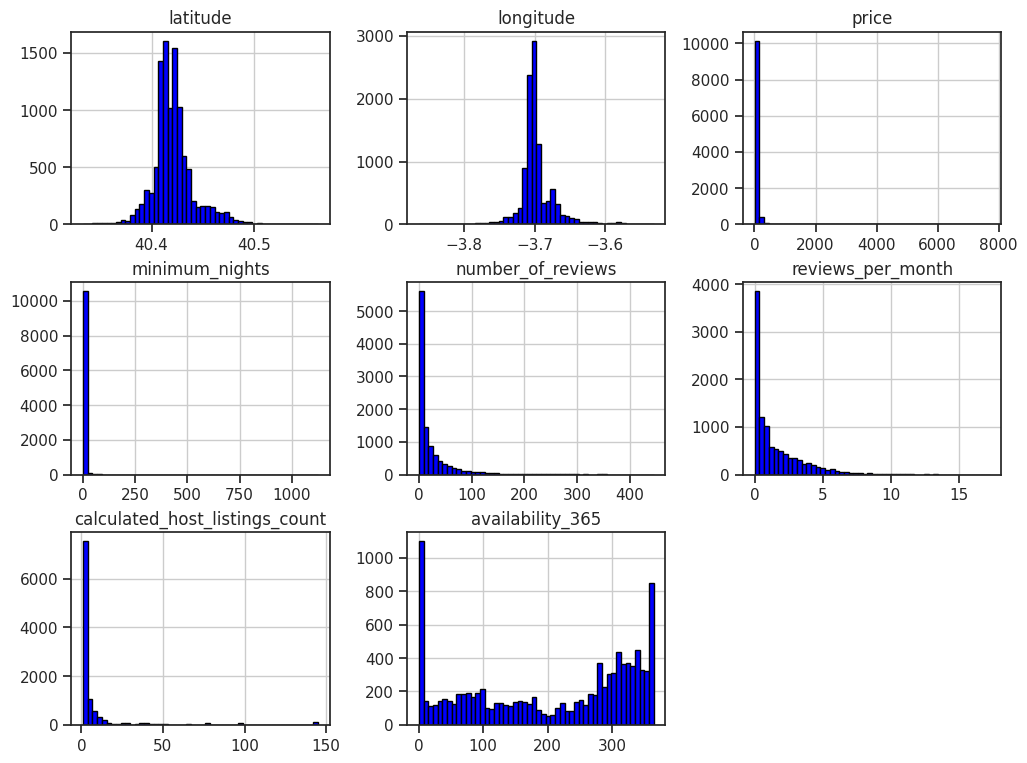

In [17]:
X_train_num.hist(figsize=(12, 9), color='blue', bins=50, edgecolor='black');

Puesto que no faltan datos, la única tarea de limpieza necesaria es eliminar datos atípicos. Se hace uso de la interactividad que ofrecen los histogramas de la librería *Plotly*. Con ésta se investigan una vez más las variables numéricas que presentaban distribuciones asimétricas con grandes colas positivas.

In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a pandas DataFrame from the data
df = X_train_num[["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count"]]


# Create the subplots figure
fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=tuple(df.columns))

# Add histograms to the subplots
for i, col in enumerate(df.columns):
    row = i + 1  # Rows start from 1 in Plotly
    trace = go.Histogram(x=df[col], name=col)
    fig.append_trace(trace, row=row, col=1)

# Update the layout and show the figure
fig.update_layout(height=800, width=1200,
                  title_text="Variables Numéricas")
fig.show()

Se observan diferentes problemas con diferentes nivel de importancia. A continuacón se discuten los **posibles** valores atípicos de cada variable:

1. La variable precio tiene 8 anuncios con un precio de más de 1000 (unidades monetarias, por ejemplo $). Mientras que la mayoría de los alojamientos cuestan menos de 1000. Sin embargo, esto no se consideran valores especialmente atípicos, ya que existen diversos alojamientos reales por esos precios.
2. En cuanto al número mínimo de noches, hay diversos anuncios con un requsito de más de 30 noches. Estos son valores poco creíbles. Especialmente los 3 alojamientos con un requisito de 360-365 días.
3. El número de reseñas y la cantidad de reseñas mensuales tienen valores más típicos/esperados, cientos y decenas respectivamente. Aunque sigue habiendo anuncios atípicos con valores bastante alejados del resto de anuncios.
4. El número calculado de anuncios por anfitrión también presenta valores difícilmente creíbles, con cientos de anuncios pertenecientes al mismo anfitrión. Incluso valores de más de 20 para esta variable se podrían considerar atípicos si se considera dónde se encuentra la mayor parte de la distribución.
5. En el caso de *availability_365* no tiene mucho sentido que haya valores iguales a cero, suponiendo que este atributo significa *disponibilidad del alojamiento al año en número de días*. Pero como se desconoce la decripción de dicha variable, no se tiene información de un(a) expert@, y existen numerosas muestras con un valor de cero (cientos de anuncios), se ha decidido no eliminar dichos valores.

En cuanto a las otras 2 variables numéricas (latitud ylongitud), a priori no se observan valores atípicos.

 Para eliminar valores atípicos de las variables numéricas se utiliza la técnica de *Isolation Forest* (Fei Tony Liu, 2008):

In [19]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=semilla_aleatoria)
outlier_pred = isolation_forest.fit_predict(X_train_num)
X_train_noOutliers = X_train.iloc[outlier_pred == 1]
y_train_noOutliers = y_train.iloc[outlier_pred == 1]

print(f"Número de valores atípicos (variables numéricas): {np.count_nonzero(outlier_pred == -1)}")

Número de valores atípicos (variables numéricas): 922


Se vuelven a asignar los datos habiendo eliminado valores atípicos:

In [20]:
# Estos son Pandas DF
X_train_noOutliers_cat = X_train_noOutliers[["neighbourhood_group", "neighbourhood"]]
X_train_noOutliers_num = X_train_noOutliers.select_dtypes(include=[np.number])
X_train_noOutliers_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9734 entries, 11619 to 6062
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        9734 non-null   float64
 1   longitude                       9734 non-null   float64
 2   price                           9734 non-null   int64  
 3   minimum_nights                  9734 non-null   int64  
 4   number_of_reviews               9734 non-null   int64  
 5   reviews_per_month               9734 non-null   float64
 6   calculated_host_listings_count  9734 non-null   int64  
 7   availability_365                9734 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 684.4 KB


Se vuelven a examinar las variables numéricas para ver el efecto de eliminar valores atípicos con *Isolation Forest*

In [21]:
print("Se han eliminado:\n")
for col in ("price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count"):
  max_value = X_train_noOutliers_num[col].max()
  print(f"Valores de '{col}' > {max_value}")

Se han eliminado:

Valores de 'price' > 1200
Valores de 'minimum_nights' > 25
Valores de 'number_of_reviews' > 187
Valores de 'reviews_per_month' > 9.81
Valores de 'calculated_host_listings_count' > 77


In [22]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a pandas DataFrame from the data
df = X_train_noOutliers_num[["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count"]]


# Create the subplots figure
fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=tuple(df.columns))

# Add histograms to the subplots
for i, col in enumerate(df.columns):
    row = i + 1  # Rows start from 1 in Plotly
    trace = go.Histogram(x=df[col], name=col)
    fig.append_trace(trace, row=row, col=1)

# Update the layout and show the figure
fig.update_layout(height=800, width=1200,
                  title_text="Variables Numéricas")
fig.show()

Por último se inspeccionan **todas** las variables numéricas, para ver como cambian sus distribuciones tras eliminar los valores atípicos.

El mayor efecto se puede apreciar en la reducción de las escalas en los ejes de coordenadas (x).

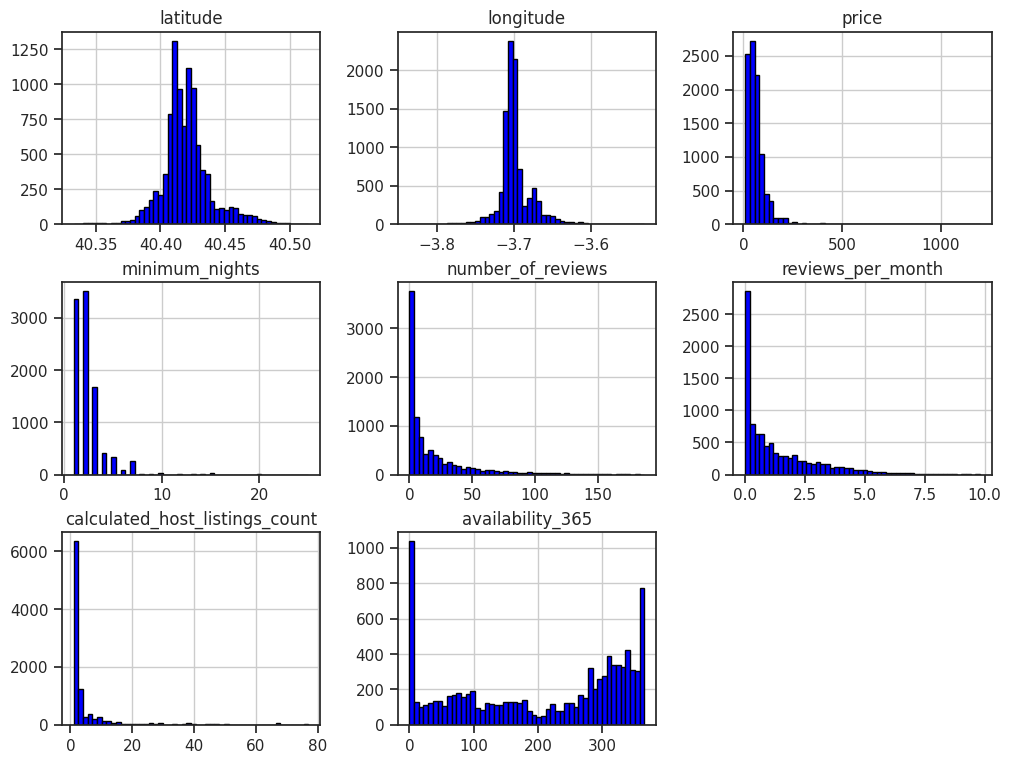

In [23]:
X_train_noOutliers_num.hist(figsize=(12, 9), color='blue', bins=50, edgecolor='black');

### 4.2.Transformar datos categóricos

Se convierten los atributos categóricos en codificaciones *one_hot*

In [24]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_train_noOutliers_cat_1hot = cat_encoder.fit_transform(X_train_noOutliers_cat) # Devuelve ndarray

### 4.3.Transformar datos numéricos

Se transforman las variables que tienen **distribuciones asimétricas**, es decir, todas menos la latitud y la longitud. Se usan los siguientes métodos:

* *price*
  * valores: >= 1
  * Transformación: **Logaritmo**
* *minimum_nights*
  * valores: >= 1
  * Transformación: Potencia (Power Transformer)
* *number_of_reviews*
  * valores: >= 0
  * Transformación: Potencia (Power Transformer)
* *reviews_per_month*
  * valores: >= 0
  * Transformación: Potencia (Power Transformer)
* *calculated_host_listings_count*
  * valores: >= 1
  * Transformación: Potencia (Power Transformer)
* *availability_365*
  * valores: >= 0
  * Transformación: Potencia (Power Transformer)

Las variables *number_of_reviews*, *reviews_per_month*, y *availability_365* contienen valores iguales a cero. Por lo que la transformación logarítmica no se puede aplicar. Se han aplicado transformaciones de potencia ya que la transformación de cuantiles genera artefactos artificailes de saturación.


Para las variables *minimum_nights* y *calculated_host_listings_count* (que tenían valores >= 1), se podría haber aplicado una transformación logarítmica. Sin embargo, se ha elegido usar la transformación de potencia (*Power Transform*) ya que ésta es capaz de reducir la variabilidad de los datos en mayor medida que la transformación logarítmica.

En el caso de la variable *price*, la transformación logarítmica es capaz de transformar los datos a una distribución normal.

In [25]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
X_train_noOutliers_num_logPrice = log_transformer.transform(X_train_noOutliers_num["price"])
X_train_noOutliers_num_logPrice.hist(color='blue', bins=30, edgecolor='black')
plt.title("Log(precio)");

In [26]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
X_train_noOutliers_num_pwrTrans = power_transformer.fit_transform(X_train_noOutliers_num.drop(["price", "latitude", "longitude"], axis=1))

### 4.4.Escalar datos numéricos

Se estandarizan todas las variables numéricas dadas sus diferentes escalas. Esto se convierte en un paso de gran importancia para algoritmos que usan distancias, como el *KNN*.

In [27]:
from sklearn.preprocessing import StandardScaler

conjunto_datos = np.hstack((X_train_noOutliers_num[["latitude", "longitude"]].to_numpy(), X_train_noOutliers_num_logPrice.to_numpy().reshape(-1, 1), X_train_noOutliers_num_pwrTrans))

std_scaler = StandardScaler()
X_train_noOutliers_num_scaled = std_scaler.fit_transform(conjunto_datos)

In [28]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a pandas DataFrame from the data

df = X_train_noOutliers_num_scaled
[_, features] = df.shape
nombresVariables = list(X_train_noOutliers_num.columns)

# Create the subplots figure
fig = make_subplots(
    rows=8, cols=1,
    shared_xaxes=True
    )

# Add histograms to the subplots
for i in range(features):
  if i in [0, 1]:
    featureName = nombresVariables[i]
  elif i == 2:
    featureName = "Log(price)"
  else:
    featureName = f"PwrTrans({nombresVariables[i]})"

  row = i + 1  # Rows start from 1 in Plotly
  trace = go.Histogram(x=df[:,i], name=featureName)
  fig.append_trace(trace, row=row, col=1)

# Update the layout and show the figure
fig.update_layout(height=800, width=1200,
                  title_text="Variables Numéricas Escaladas")

fig.update_xaxes(showticklabels=True)
fig.show()

Se agrupan todos los pasos en un fragmento de código:

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Pipeline para variables categóricas
pipeline_cat = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown='ignore'))

# Pipeline para Latitud y Longitud
pipeline_num_geo = make_pipeline(StandardScaler())

# Pipeline para precio
pipeline_num_log = make_pipeline(FunctionTransformer(np.log, inverse_func=np.exp), StandardScaler())

# Pipeline para el resto de variables numéricas
pipeline_num_resto = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler())

# Aplicando transformaciones al conjunto de datos de entrenamiento
preprocesado = ColumnTransformer([
    ("categoricas", pipeline_cat, ["neighbourhood_group", "neighbourhood"]),
    ("geograficas", pipeline_num_geo, ["latitude", "longitude"]),
    ("precio", pipeline_num_log, ["price"]),
    ("resto", pipeline_num_resto, ["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]),
])


## 5.Selección de modelos (Entrenamiento)

In [30]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

clasificador_NB = make_pipeline(preprocesado, GaussianNB())
clasificador_NB.fit(X_train_noOutliers, y_train_noOutliers)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categoricas',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['neighbourhood_group',
                                                   'neighbourhood']),
                                                 ('geograficas',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude']),
                                                 ('precio',
                                                  Pipeline(steps=[('functio...
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('resto',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365'])])),
                ('gaussiannb', GaussianNB())])

In [31]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

clasificador_KNN = make_pipeline(preprocesado, KNeighborsClassifier(n_neighbors=9))
clasificador_KNN.fit(X_train_noOutliers, y_train_noOutliers)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categoricas',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['neighbourhood_group',
                                                   'neighbourhood']),
                                                 ('geograficas',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude']),
                                                 ('precio',
                                                  Pipeline(steps=[('functio...
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('resto',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=9))])

In [53]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

clasificador_tree = make_pipeline(preprocesado, DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=5, max_depth=6, random_state=semilla_aleatoria))
clasificador_tree.fit(X_train_noOutliers, y_train_noOutliers)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categoricas',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['neighbourhood_group',
                                                   'neighbourhood']),
                                                 ('geograficas',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude']),
                                                 ('precio',
                                                  Pipeline(steps=[('functio...
                                                 ('resto',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, max_leaf_nodes=50,
                                        min_samples_split=5,
                                        random_state=96))])

### Evaluación de los 3 modelos
A continuación se presentan los valores de las exactitudes de los 10 modelos entrenados por cada clasificador usando validación cruzada

In [33]:
from sklearn.model_selection import cross_val_score, cross_val_predict

y_train_pred_NB = cross_val_predict(clasificador_NB, X_train_noOutliers, y_train_noOutliers, cv=10)
cv_scores_NB = cross_val_score(clasificador_NB, X_train_noOutliers, y_train_noOutliers, cv=10, scoring='accuracy')
cv_scores_NB

array([0.16324435, 0.16221766, 0.17043121, 0.17967146, 0.15621788,
       0.15827338, 0.17163412, 0.14696814, 0.19218911, 0.18293936])

In [34]:
y_train_pred_KNN = cross_val_predict(clasificador_KNN, X_train_noOutliers, y_train_noOutliers, cv=10)
cv_scores_KNN = cross_val_score(clasificador_KNN, X_train_noOutliers, y_train_noOutliers, cv=10, scoring='accuracy')
cv_scores_KNN

array([0.84702259, 0.862423  , 0.85420945, 0.87268994, 0.86536485,
       0.8684481 , 0.8705036 , 0.8602261 , 0.8725591 , 0.8602261 ])

In [35]:
y_train_pred_tree = cross_val_predict(clasificador_tree, X_train_noOutliers, y_train_noOutliers, cv=10)
cv_scores_tree = cross_val_score(clasificador_tree, X_train_noOutliers, y_train_noOutliers, cv=10, scoring='accuracy')
cv_scores_tree

array([0.85934292, 0.85420945, 0.85626283, 0.85523614, 0.86536485,
       0.85200411, 0.8643371 , 0.8602261 , 0.89003083, 0.86947585])

Matrices de Confusión

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

fuente = 10
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_NB, ax=axs[0], normalize="true", values_format=".0%")
axs[0].set_title("Naive Bayes")
axs[0].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_KNN, ax=axs[1], normalize="true", values_format=".0%")
axs[1].set_title("KNN")
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_tree, ax=axs[2], normalize="true", values_format=".0%")
axs[2].set_title("Decision Tree")
axs[2].set_yticks([])
axs[2].tick_params(axis='x', labelsize=6)


plt.show()

In [59]:
ponderaciones_NB = (y_train_pred_NB != y_train_noOutliers)
ponderaciones_KNN = (y_train_pred_KNN != y_train_noOutliers)
ponderaciones_tree = (y_train_pred_tree != y_train_noOutliers)

fuente = 10
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_NB, sample_weight = ponderaciones_NB, ax=axs[0], normalize="true", values_format=".0%")
axs[0].set_title("Naive Bayes")
axs[0].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_KNN, sample_weight = ponderaciones_KNN, ax=axs[1], normalize="true", values_format=".0%")
axs[1].set_title("KNN")
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_tree, sample_weight = ponderaciones_tree, ax=axs[2], normalize="true", values_format=".0%")
axs[2].set_title("Decision Tree")
axs[2].set_yticks([])
axs[2].tick_params(axis='x', labelsize=6)

fig.suptitle("Errores normalizados por filas")
plt.show()

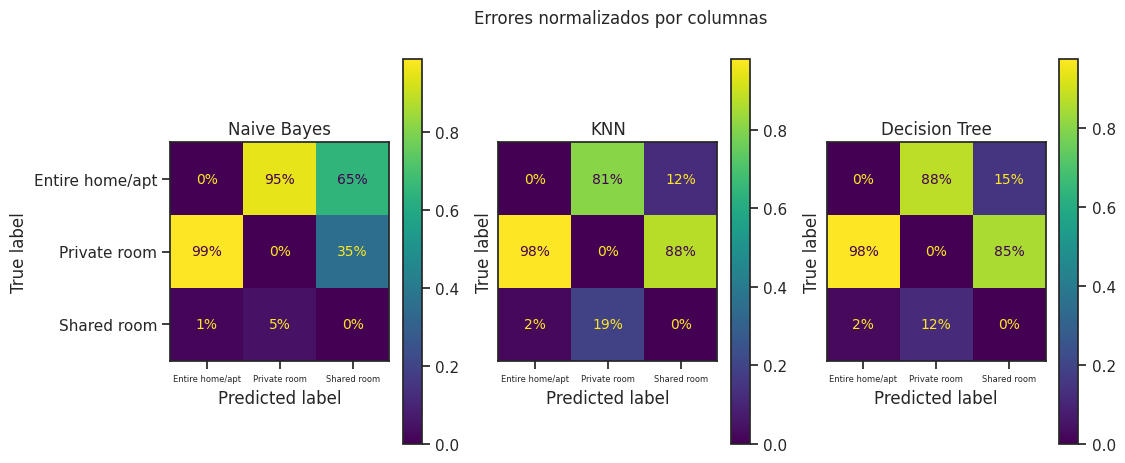

In [38]:
ponderaciones_NB = (y_train_pred_NB != y_train_noOutliers)
ponderaciones_KNN = (y_train_pred_KNN != y_train_noOutliers)
ponderaciones_tree = (y_train_pred_tree != y_train_noOutliers)

fuente = 10
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_NB, sample_weight = ponderaciones_NB, ax=axs[0], normalize="pred", values_format=".0%")
axs[0].set_title("Naive Bayes")
axs[0].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_KNN, sample_weight = ponderaciones_KNN, ax=axs[1], normalize="pred", values_format=".0%")
axs[1].set_title("KNN")
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_train_noOutliers, y_train_pred_tree, sample_weight = ponderaciones_tree, ax=axs[2], normalize="pred", values_format=".0%")
axs[2].set_title("Decision Tree")
axs[2].set_yticks([])
axs[2].tick_params(axis='x', labelsize=6)

fig.suptitle("Errores normalizados por columnas")
plt.show()

## 6.Puesta a punto del modelo

Se ajustan hiperparámetros de 2 de los modelos para mejorar su rendimiento

In [39]:
w

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categoricas',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['neighbourhood_group',
                                                                          'neighbourhood']),
                                                                        ('geograficas',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude']),
                                                                        ('prec...
                                                                         Pipeline(steps=[('powertransformer',
                                                                                          PowerTransformer(standardize=False)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['minimum_nights',
                                                                          'number_of_reviews',
                                                                          'reviews_per_month',
                                                                          'calculated_host_listings_count',
                                                                          'availability_365'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=9))]),
             param_grid={'kneighborsclassifier__n_neighbors': [5, 7, 9, 11,
                                                               13]},
             scoring='accuracy')

In [40]:
# Tiempo de ejecución muy elevado!!!
param_grid_tree = {'decisiontreeclassifier__max_leaf_nodes': range(2, 51),
                   'decisiontreeclassifier__min_samples_split': range(2, 7),
                   'decisiontreeclassifier__max_depth': range(1, 21)}
grid_search_tree = GridSearchCV(clasificador_tree, param_grid_tree, cv=10, scoring='accuracy')
# grid_search_tree.fit(X_train_noOutliers, y_train_noOutliers)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categoricas',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['neighbourhood_group',
                                                                          'neighbourhood']),
                                                                        ('geograficas',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude']),
                                                                        ('prec...
                                                                          'number_of_reviews',
                                                                          'reviews_per_month',
                                                                          'calculated_host_listings_count',
                                                                          'availability_365'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=96))]),
             param_grid=[{'decisiontreeclassifier__max_leaf_nodes': range(2, 51)},
                         {'decisiontreeclassifier__min_samples_split': range(2, 7)},
                         {'decisiontreeclassifier__max_depth': range(1, 21)}],
             scoring='accuracy')

### Evaluación en el conjunto de prueba

In [54]:
X_test = test_set.drop("room_type", axis=1)
y_test = test_set["room_type"].copy()

y_test_pred_NB = clasificador_NB.predict(X_test)
y_test_pred_KNN = grid_search_KNN.best_estimator_.predict(X_test)
y_test_pred_tree = clasificador_tree.predict(X_test) # Se usa el modelo mostrado anteriormente con los parámetros obtenidos por el GridSearchCV

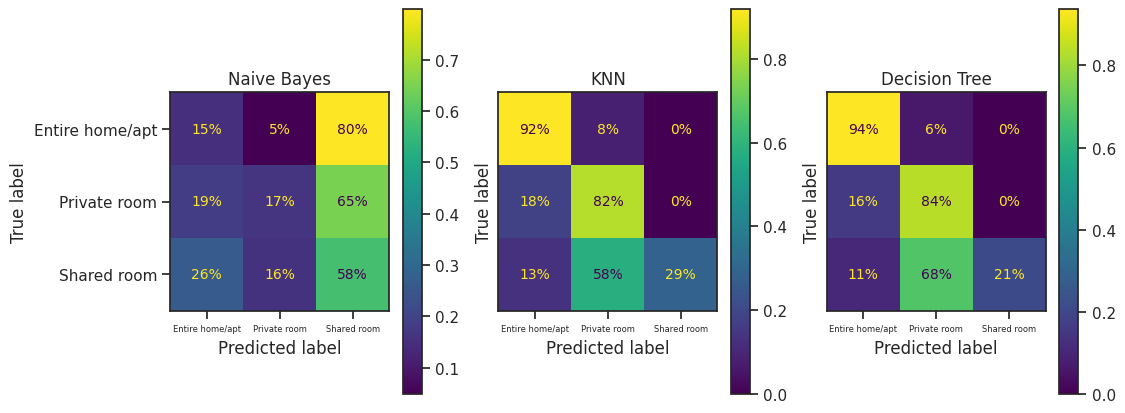

In [55]:
fuente = 10
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_NB, ax=axs[0], normalize="true", values_format=".0%")
axs[0].set_title("Naive Bayes")
axs[0].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_KNN, ax=axs[1], normalize="true", values_format=".0%")
axs[1].set_title("KNN")
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_tree, ax=axs[2], normalize="true", values_format=".0%")
axs[2].set_title("Decision Tree")
axs[2].set_yticks([])
axs[2].tick_params(axis='x', labelsize=6)


plt.show()

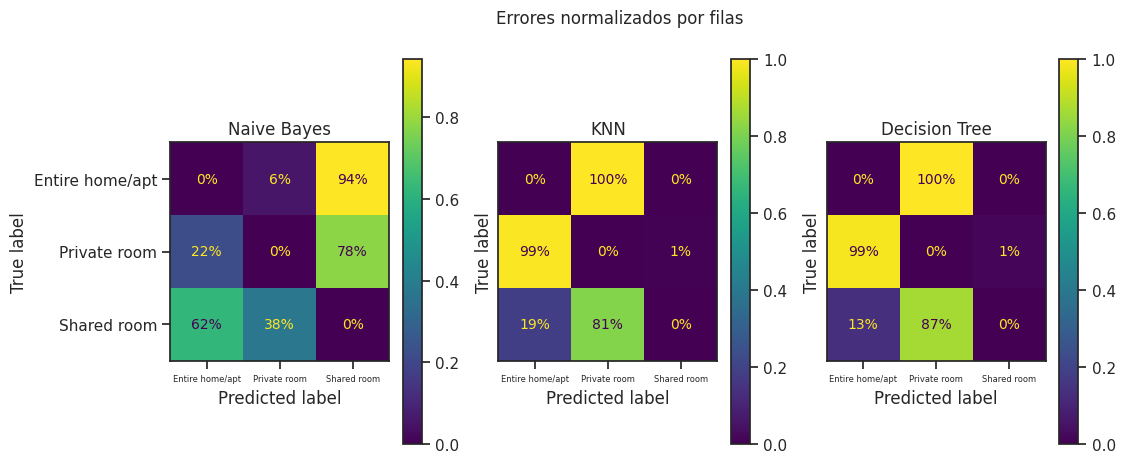

In [56]:
ponderaciones_test_NB = (y_test_pred_NB != y_test)
ponderaciones_test_KNN = (y_test_pred_KNN != y_test)
ponderaciones_test_tree = (y_test_pred_tree != y_test)

fuente = 10
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_NB, sample_weight = ponderaciones_test_NB, ax=axs[0], normalize="true", values_format=".0%")
axs[0].set_title("Naive Bayes")
axs[0].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_KNN, sample_weight = ponderaciones_test_KNN, ax=axs[1], normalize="true", values_format=".0%")
axs[1].set_title("KNN")
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_tree, sample_weight = ponderaciones_test_tree, ax=axs[2], normalize="true", values_format=".0%")
axs[2].set_title("Decision Tree")
axs[2].set_yticks([])
axs[2].tick_params(axis='x', labelsize=6)

fig.suptitle("Errores normalizados por filas")
plt.show()

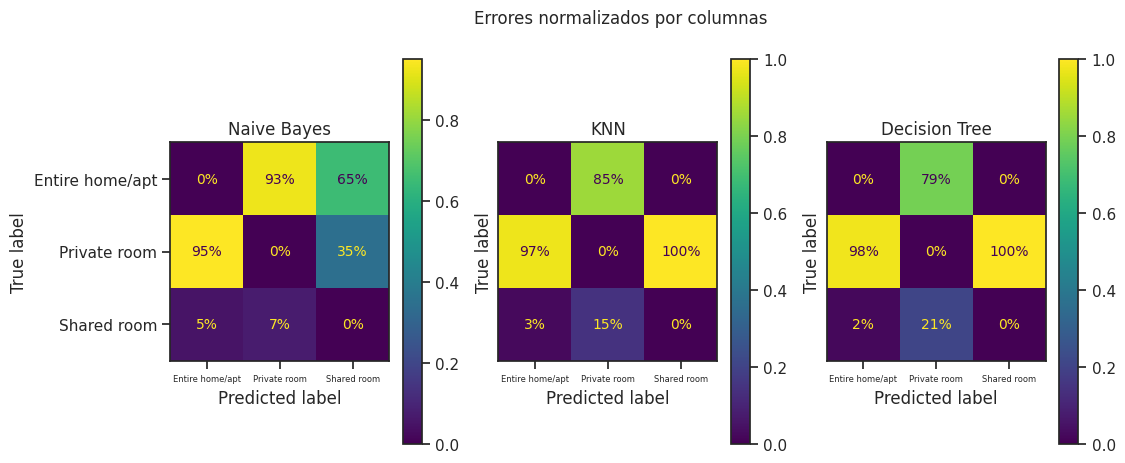

In [57]:
ponderaciones_test_NB = (y_test_pred_NB != y_test)
ponderaciones_test_KNN = (y_test_pred_KNN != y_test)
ponderaciones_test_tree = (y_test_pred_tree != y_test)

fuente = 10
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_NB, sample_weight = ponderaciones_test_NB, ax=axs[0], normalize="pred", values_format=".0%")
axs[0].set_title("Naive Bayes")
axs[0].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_KNN, sample_weight = ponderaciones_test_KNN, ax=axs[1], normalize="pred", values_format=".0%")
axs[1].set_title("KNN")
axs[1].set_yticks([])
axs[1].tick_params(axis='x', labelsize=6)

plt.rc('font', size=fuente)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_tree, sample_weight = ponderaciones_test_tree, ax=axs[2], normalize="pred", values_format=".0%")
axs[2].set_title("Decision Tree")
axs[2].set_yticks([])
axs[2].tick_params(axis='x', labelsize=6)

fig.suptitle("Errores normalizados por columnas")
plt.show()

## Conclusiones

* DATOS
  * Los datos no presentan valores faltantes, aunque si existen valores atípicos. Estos se pueden eliminar con algoritmos como *Isolation Forest*.
  * Los datos presentan atributos extremadamente desbalanceados, por ejemplo, el precio.
    * Transformaciones como el logaritmo pueden ser aplicadas a distribuciones en las que el valor mínimo es 1.
  * Otros atributos numéricos contienen valores iguales a cero, por lo tanto se deben aplicar otras transformaciones para reducir el desbalance, como transformaciones de potencia.
  * Las variables categóricas se convierten en representaciones numéricas mediante *one hot encoding*.
  * Los datos se escalan para que todas las variables se encuentren en una escala similar. Esto es crucial para algoritmos clasificadores basados en distancias euclídeas (KNN).
  * El algoritmo de *Naive Bayes* asume una independencia entre las variables, lo cual se puede comprobar antes y después de las transformaciones mediante las correlaciones entre los atributos.
  * Usando *pipelines* se facilita el proceso de construcción y evaluación de los modelos
* MODELOS
  * En el modelo de *Naive Bayes* entrenado, existen más falsos positivos que falsos negativos (más valores **encima** de la diagonal de las matrices de confusión). En los modelos de *KNN* y de *árbol de decisión* pasa lo contrario, hay más falsos negativos (más valores **debajo** de la diagonal de las matrices de confusión).
  * Los 3 modelos presentan un rendimiento similar o incluso mejor en los datos de evaluación que en los de entrenamiento.
  * El modelo con mejor rendiemiento es el árnol de decisión, ya que es capaz de clasificar correctamente un mayor porcentaje de los datos de evaluacón. Aunque el modelo de *KNN* tiene un rendimiento bastante similar, y su entrenamiento y búsqueda del valor óptimo es menos costosa (computacionalmente) que la búsqueda de los hiperparámetros del árbol de decisión óptimo.
  * Por último, atentiendo a las matrices de los errores normalizados los tres modelos cometen los mismos tipos de errores tanto en el conjunto de entrenamiento como en el de evaluación. Por ejemplo, en el árbol de decisión, el 99% de los errores en la clase verdadera de alojamiento entero está en clasificaciones erróneas como habitaciónes privadas.

  El gran problema de este conjunto de datos es el gran desbalance de los atributos. Las distribuciones son realmente asimétricas y las transformaciones son cruciales para un buen rendimiento de los modelos.